# Importance Weighted Autoencoders

Implementation of the paper [Importance Weighted Autoencoders](https://arxiv.org/abs/1509.00519).

Base VAE architecture is based on the paper [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114).

Author(s): Erik Lidbjörk.

Date: 2024.


## Problem description

Assume we have data $\mathcal D = \left\{\mathbf x^{(n)}\right\}_{n=1}^N, \mathbf x^{(n)}\in\mathbb R^{D}$, which contains $N$ i.i.d. continous or discrete random variables $\mathbf X^{(n)}=\left(X_1^{(n)},...,X_D^{(n)}\right)$. We assume that the data is generated by a process depending on an unobserved (latent) continous random variable $z$. Assume that the joint distribution $p_{\boldsymbol \theta^\star}(\mathbf x, \mathbf z)$ is dependent on some hidden parameter $\boldsymbol \theta^\star \in \boldsymbol \Theta$. We can write the joint using Baye's rule as
$$
p_{\boldsymbol \theta^\star}(\mathbf x, \mathbf z) = p_{\boldsymbol \theta^\star}(\mathbf x| \mathbf z)p_{\boldsymbol \theta^\star}(\mathbf z).
$$
So we can view the data as being generated by $\mathbf x \sim p_{\boldsymbol \theta^\star}(\cdot|\mathbf z)$ (likelihood distribution) and $\mathbf z \sim p_{\boldsymbol \theta^\star}(\cdot)$ (prior distribution). Assume that the likelihood and prior comes from some parametric family of distributions $p_{\boldsymbol \theta}(\mathbf x| \mathbf z)=\prod_{n=1}^N p_{\boldsymbol \theta}(\mathbf x_n| \mathbf z)$ and $p_{\boldsymbol \theta}(\mathbf z)$ respectively, so $\boldsymbol \theta^\star$ is a realization of $\mathbf \theta$ with some unknown value.

We would like to know the posterior distribution (for e.g. density estimation)
$$
p_{\boldsymbol \theta}(\mathbf z| \mathbf x) = \frac{p_{\boldsymbol \theta}(\mathbf x|\mathbf z)p_{\boldsymbol \theta}(\mathbf z)}{p_{\boldsymbol \theta}(\mathbf x)}.
$$
The normalization factor (evidence)
$$
p_{\boldsymbol \theta}(\mathbf x) = \int_{\boldsymbol \Theta} p_{\boldsymbol \theta}(\mathbf x|\mathbf z)p_{\boldsymbol \theta}(\mathbf z) \mathrm{d}\boldsymbol \theta
$$ is however hard to compute in general (intracteble integral). Like in variational inference (VI), we instead approximate the posterior with a simpler (tractable) distribution $q_{\boldsymbol \phi}(\mathbf z|\mathbf x)$ which we call the variational distribution. We then have two parameters, the generative parameters $\mathbf \theta$ and variational parameters $\mathbf \phi$.

### ELBO
Our goal is maximing the ELBO (variational lower bound) $\mathcal L(\boldsymbol \theta, \boldsymbol \phi, \mathbf x)$ with respects to the parameters.
$$
\mathcal L(\boldsymbol \theta, \boldsymbol \phi, \mathbf x) = \mathbb E_{\mathbf z\sim q_{\boldsymbol \phi}(\cdot|\mathbf x)}\left[ \log\frac{ p_{\boldsymbol \theta}(\mathbf x,\mathbf z)}{q_{\boldsymbol \phi}(\mathbf z|\mathbf x)} \right] = \mathbb E_{\mathbf z \sim q_{\boldsymbol \phi}(\cdot|\mathbf x)}\left[\log p_{\boldsymbol \theta}(\mathbf x|\mathbf z) \right] - D_\text{KL}(q_{\boldsymbol \phi}(\mathbf z|\mathbf x)|p_{\boldsymbol \theta}(\mathbf z)).
$$
So the ELBO can be expressed as the difference of expected log likelihood, also called the reconstruction loss, and the KL divergence between the variational postierior and prior distributions.

We can Monte Carlo approximate the ELBO as follows (using $L$ samples):
$$
\mathcal L(\boldsymbol \theta, \boldsymbol \phi, \mathbf x) \approx \frac{1}{L} \sum_{l=1}^L \log\frac{ p_{\boldsymbol \theta}(\mathbf x, \mathbf z_l)}{q_{\boldsymbol \phi}(\mathbf z_l|\mathbf x)}.
$$
For a single sample $\mathbf z$ ($L=1$), this simply becomes
$$
\mathcal L(\boldsymbol \theta, \boldsymbol \phi, \mathbf x) \approx \log p_{\boldsymbol \theta}(\mathbf x|\mathbf z) - D_\text{KL}(q_{\boldsymbol \phi}(\mathbf z|\mathbf x)|p_{\boldsymbol \theta}(\mathbf z)).
$$
 


## Variational Autoencoder
A Variational autoencoder (VAE) consists of two parts: an *encoder* which maps a value from the input space to a latent space ($\mathbf x \to \mathbf z$), and a decoder which maps from the latent space to the input space ($\mathbf z \to \mathbf x$). With this we can for example reconstruct input by first getting a sample $\mathbf x \sim p_{\boldsymbol \theta}(\cdot)$, then encoding it getting $\mathbf z \sim \mathbf q_{\boldsymbol \phi}(\cdot|\mathbf x)$, and then reconstructing it again $\mathbf x \sim p_{\boldsymbol \theta}(\cdot|\mathbf z)$. We can also generate samples by sampling from the latent distribution $\mathbf z \sim p(\cdot)$ and then $\mathbf x \sim p_{\boldsymbol \theta}(\cdot|\mathbf z)$.

The encoder and decoder are both implemented as MLPs, where the outputs of the networks are the generative- and variational parameters ($\mathbf \theta$ and $\mathbf \phi$) respectively.

### Assumptions
Assume the likelihood function $p_{\boldsymbol \theta}(\mathbf x_i^{(n)}|\mathbf z)$ to be Bernoulli distributed, $X_i^{(n)}| \theta_i \sim \text{Be}(\theta_i), \theta_i\in[0,1]$ (the likelihood could be something else, like the $\beta$-distribution or Gaussian, which might make more sense since the data (image pixels) is not binary), where $\boldsymbol \theta = \left(\theta_1,...,\theta_D\right)$.
<!--$$
p(x|z)=\theta^{x_n}(1-\theta)^{1-x_n}=\begin{cases} \theta, & x_n=1 \\ 1-\theta & x_n=0 \end{cases}.
$$-->
<!--Assume
#$$
#p(x|z) = \prod_{n=1}^N p(x_n|z) = \prod_{n=1}^N \theta^{x_n}(1-\theta)^{1-x_n}.
#$$-->
Assume the prior $p(\mathbf z)$ to be multivariate standard normal, $\mathbf Z \sim \mathcal N(\mathbf 0, \mathbf I)$.
<!--$$
p_\theta(z)=p(z) = \frac{1}{\sqrt{2\pi}}e^{-\frac{z^2}{2}}.
$$-->
Assume the variational distribution $q_{\boldsymbol \phi}(\mathbf z|\mathbf x)$ to be multivariate normal with diagonal covariance matrix $\mathbf Z|\mathbf x^{(n)} \sim \mathcal N(\boldsymbol \mu,\text{diag}(\boldsymbol \sigma^2))$ where $\boldsymbol \phi = (\boldsymbol \mu, \boldsymbol \sigma^2)$.
<!--$$
q_\phi(z|x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(z-\mu)^2}{2\sigma^2}}.
$$-->

## Importance Weighted Autoencoder
A Importance Weighted Autoencoder is a variant of the original VAE architecure, and differs in that it is trained to maximize a different ELBO (IWELBO) corresponding to the $k$-sample importance weighting
estimate of the log-likelihood. Specifically, we want to maximize
$$
\mathcal L_k(\boldsymbol \theta, \boldsymbol \phi, \mathbf x) = \mathbb E_{\mathbf z_1,...,\mathbf z_k\sim q_{\boldsymbol \phi}(\cdot|\mathbf x)}\left[ \log\frac{1}{k}\sum_{i=1}^k\frac{ p_{\boldsymbol \theta}(\mathbf x,\mathbf z_i)}{q_{\boldsymbol \phi}(\mathbf z_i|\mathbf x)} \right].
$$

Again, using a single Monte Carlo sample, we can approximate the IWELBO with 
$$
\mathcal L_k(\boldsymbol \theta, \boldsymbol \phi, \mathbf x) \approx \log\frac{1}{k}\sum_{i=1}^k\frac{ p_{\boldsymbol \theta}(\mathbf x,\mathbf z_i)}{q_{\boldsymbol \phi}(\mathbf z_i|\mathbf x)} = \text{LSE}(y_1,...,y_k) - \log k,
$$
where $\text{LSE}$ is LogSumExp defined as
$$
\text{LSE}(x_1,...,x_n)=\log(\exp(x_1)+...+\exp(x_n)),
$$
and
$$
y_i = \log\frac{ p_{\boldsymbol \theta}(\mathbf x,\mathbf z_i)}{q_{\boldsymbol \phi}(\mathbf z_i|\mathbf x)}= \log p_{\boldsymbol \theta}(\mathbf x|\mathbf z_i) - D_\text{KL}(q_{\boldsymbol \phi}(\mathbf z_i|\mathbf x)|p_{\boldsymbol \theta}(\mathbf z_i)).
$$
IWAEs have the following nice properties:
Firstly, the lower bounds satisfy 
$$
\mathcal L_k \leq \mathcal L_{k+1} \leq \log p(\mathbf x), \forall k = 1,2,...
$$
Additionally, if $p(\mathbf x, \mathbf z)/q(\mathbf z|\mathbf x)$ is bounded, then 
$$
\lim_{k \to \infty} \mathcal L_k = \log p(\mathbf x).
$$

In [2]:
from iwae_models import IWAE
from iwae_losses import IWELBOLoss
from iwae_visualize import *
from iwae_train import *
from iwae_data import *

import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from torchsummary import summary

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print("device:", device)

seed = 1337
g_np = np.random.default_rng(seed)
g_torch = torch.Generator(device).manual_seed(seed)

device: cuda


Load MNIST and Omniglot datasets.

In [9]:
training_data_MINST, test_data_MINST = load_data('MNIST')
training_data_Omniglot, test_data_Omniglot = load_data('Omniglot')

Files already downloaded and verified
Files already downloaded and verified


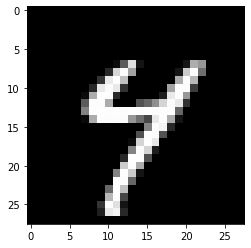

In [10]:
visualize_image(sample_image(training_data_MINST, g_np))

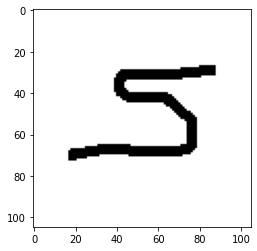

In [12]:
visualize_image(sample_image(training_data_Omniglot, g_np))

### Encoder:
$f_E(\mathbf x)=\boldsymbol \phi = (\boldsymbol \mu, \boldsymbol \sigma^2)$.

### Decoder:
$f_D(\mathbf z)=\boldsymbol \theta$.

## Training
Train an importance weighted variational autoencoder. 

### Specify training parameters and hyperparameter, and create model

In [4]:
batch_size = 256
training_data = training_data_MINST
test_data = test_data_MINST
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             generator=g_torch)
test_loader = DataLoader(test_data, 
                         batch_size=batch_size, 
                         shuffle=True,
                         generator=g_torch)

in_features = np.prod(training_data[0][0].shape)
hidden_features_encoder = (400,400)
hidden_features_decoder = (400,400)
latent_features = 3
nonlinear_encoder = 'relu'
nonlinear_decoder = 'relu'
k = 5 # For importance samplig (set k=1 for regular VAE).
num_epochs = 20

lr = .0001
elbo = IWELBOLoss(k)
write_tb = False

model = IWAE(in_features, 
             hidden_features_encoder, 
             hidden_features_decoder, 
             latent_features, 
             nonlinear_encoder, 
             nonlinear_decoder, 
             k, 
             g_torch).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = lambda input, target, *output: elbo(input, *output) 

summary(model, (in_features,), batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [256, 400]         314,000
              ReLU-2                 [256, 400]               0
            Linear-3                 [256, 400]         160,400
              ReLU-4                 [256, 400]               0
            Linear-5                   [256, 3]           1,203
            Linear-6                   [256, 3]           1,203
          Softplus-7                   [256, 3]               0
           Encoder-8         [[-1, 3], [-1, 3]]               0
            Linear-9              [256, 2, 400]           1,600
             ReLU-10              [256, 2, 400]               0
           Linear-11              [256, 2, 400]         160,400
             ReLU-12              [256, 2, 400]               0
           Linear-13              [256, 2, 784]         314,384
          Sigmoid-14              [256,

In [5]:
# Write to tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs
write_tb = True

Launching TensorBoard...

### Train model

In [6]:
train(model=model,              
      loss_fn=loss_fn,          
      optimizer=optimizer, 
      training_loader=training_loader, 
      test_loader=test_loader, 
      num_epochs=num_epochs, 
      save_model=True,
      write_tb=write_tb,
      device=device)

Epoch 1 | avg loss 254.8197014341963: 100%|██████████| 235/235 [00:10<00:00, 22.67it/s] 


Training loss = 255.66508289093667 | Test loss = 196.1702117919922


Epoch 2 | avg loss 184.47100232712765: 100%|██████████| 235/235 [00:10<00:00, 22.10it/s]


Training loss = 185.1872893637799 | Test loss = 172.0044403076172


Epoch 3 | avg loss 167.6548369062708: 100%|██████████| 235/235 [00:09<00:00, 24.34it/s] 


Training loss = 168.35504325704372 | Test loss = 164.43601989746094


Epoch 4 | avg loss 161.99734471097906: 100%|██████████| 235/235 [00:10<00:00, 23.10it/s]


Training loss = 162.7107955607962 | Test loss = 160.27716064453125


Epoch 5 | avg loss 158.82269436450716: 100%|██████████| 235/235 [00:12<00:00, 18.99it/s]


Training loss = 159.48408742052445 | Test loss = 157.5673065185547


Epoch 6 | avg loss 156.21865734343834: 100%|██████████| 235/235 [00:11<00:00, 20.45it/s]


Training loss = 156.90537167812914 | Test loss = 155.61805725097656


Epoch 7 | avg loss 154.09040851998836: 100%|██████████| 235/235 [00:13<00:00, 17.53it/s]


Training loss = 154.73633254030918 | Test loss = 153.25929260253906


Epoch 8 | avg loss 152.44499901304854: 100%|██████████| 235/235 [00:10<00:00, 22.08it/s]


Training loss = 153.10016921023106 | Test loss = 152.37063598632812


Epoch 9 | avg loss 151.04747385877243: 100%|██████████| 235/235 [00:09<00:00, 25.00it/s]


Training loss = 151.68176444844997 | Test loss = 150.58602905273438


Epoch 10 | avg loss 149.70665997444314: 100%|██████████| 235/235 [00:09<00:00, 23.96it/s]


Training loss = 150.36631222988697 | Test loss = 149.5242156982422


Epoch 11 | avg loss 148.43663732650433: 100%|██████████| 235/235 [00:09<00:00, 23.65it/s]


Training loss = 149.0297747023562 | Test loss = 148.01724243164062


Epoch 12 | avg loss 147.1997490416182: 100%|██████████| 235/235 [00:10<00:00, 23.19it/s] 


Training loss = 147.82211849131482 | Test loss = 146.57626342773438


Epoch 13 | avg loss 146.11964267162566: 100%|██████████| 235/235 [00:11<00:00, 20.77it/s]


Training loss = 146.74740847323804 | Test loss = 145.84983825683594


Epoch 14 | avg loss 145.1761519411777: 100%|██████████| 235/235 [00:09<00:00, 23.85it/s] 


Training loss = 145.78484587973736 | Test loss = 145.3996124267578


Epoch 15 | avg loss 144.35484391882065: 100%|██████████| 235/235 [00:10<00:00, 22.49it/s]


Training loss = 144.96950651128242 | Test loss = 144.8157501220703


Epoch 16 | avg loss 143.61514054968: 100%|██████████| 235/235 [00:10<00:00, 23.01it/s]   


Training loss = 144.2000829818401 | Test loss = 143.46771240234375


Epoch 17 | avg loss 142.98096027780088: 100%|██████████| 235/235 [00:11<00:00, 21.03it/s]


Training loss = 143.58404320250168 | Test loss = 143.7373504638672


Epoch 18 | avg loss 142.42715954070397: 100%|██████████| 235/235 [00:11<00:00, 20.68it/s]


Training loss = 142.9985009376039 | Test loss = 142.1234893798828


Epoch 19 | avg loss 141.8640121784616: 100%|██████████| 235/235 [00:11<00:00, 20.51it/s] 


Training loss = 142.51135072099402 | Test loss = 141.5894012451172


Epoch 20 | avg loss 141.37608499729888: 100%|██████████| 235/235 [00:11<00:00, 20.13it/s]


Training loss = 141.96633989050034 | Test loss = 141.5217742919922


### Load model

In [10]:
model_filename = input().strip()
model_dir = './models'
model_path = model_dir + '/' + model_filename
model.load_state_dict(torch.load(model_path, weights_only=True))
summary(model, (in_features,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         314,000
              ReLU-2                  [-1, 400]               0
            Linear-3                  [-1, 400]         160,400
              ReLU-4                  [-1, 400]               0
            Linear-5                    [-1, 3]           1,203
            Linear-6                    [-1, 3]           1,203
          Softplus-7                    [-1, 3]               0
           Encoder-8         [[-1, 3], [-1, 3]]               0
            Linear-9               [-1, 2, 400]           1,600
             ReLU-10               [-1, 2, 400]               0
           Linear-11               [-1, 2, 400]         160,400
             ReLU-12               [-1, 2, 400]               0
           Linear-13               [-1, 2, 784]         314,384
          Sigmoid-14               [-1,

## Visualization
Visualize some reconstructed and generated images from the model.

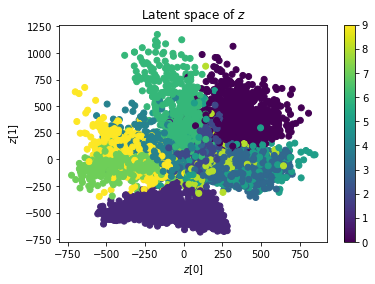

In [18]:
visualize_latent_space_2D(model, test_data)

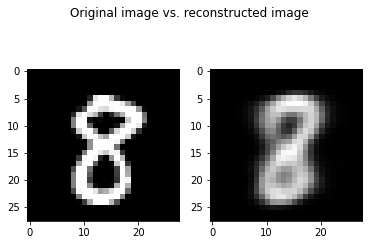

In [15]:
visualize_reconstructed_image(sample_image(test_data, g_np), model)

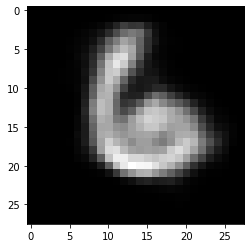

In [17]:
visualize_generated_image(model, training_data[0][0].shape, sample_likelihood=False)

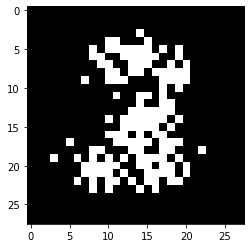

In [20]:
visualize_generated_image(model, training_data[0][0].shape, sample_likelihood=True)

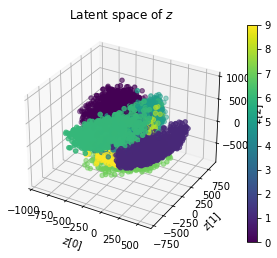

In [6]:
visualize_latent_space_3D(model, test_data)